# Introduction 

Welcome to the second notebook in our series on **NLP with Huggingface and TensorFlow!** 

In the previous notebook, we explored the different features and functionalities of the Huggingface library, including different pipelines and how to use them for NLP tasks like sentiment analysis and text generation. 

Now, in this notebook, we will dive deeper into the world of NLP by learning how to **fine-tune BERT-based models for the sentence-pair classification task**. This task is a part of the semantic textual similarity problem where we have two pairs of questions, and we want to model the textual interaction between them.

> To understand this consider the following pair of sentences and check if the following pair of two sentences are semantically similar or not.:
* **"Is the Earth flat?" vs. "Is the Earth round?"** *- These two questions are asking about the same event, but they are phrased in opposite ways. They are semantically similar, but not identical.*
* **"Did NASA fake the moon landing?" vs. "Was the moon landing real?"**  *- These two questions are asking about the same event, but they are phrased in opposite ways. They are semantically similar, but not identical.*
* **"Is pineapple a suitable pizza topping?" vs. "Is pepperoni a suitable pizza topping?"** *- These two questions are asking about different toppings for pizza. They are not semantically similar, and the answer to one question does not necessarily inform the answer to the other. *italicized text*
* **"Is it ethical to eat meat?" vs. "Is it ethical to be a vegan?"** *- These two questions are asking about different dietary choices. They are not semantically similar, and the answer to one question does not necessarily inform the answer to the other.*

By training a model to classify whether two sentences are semantically similar or not, we can teach machines to understand the nuances of language and make more accurate predictions.







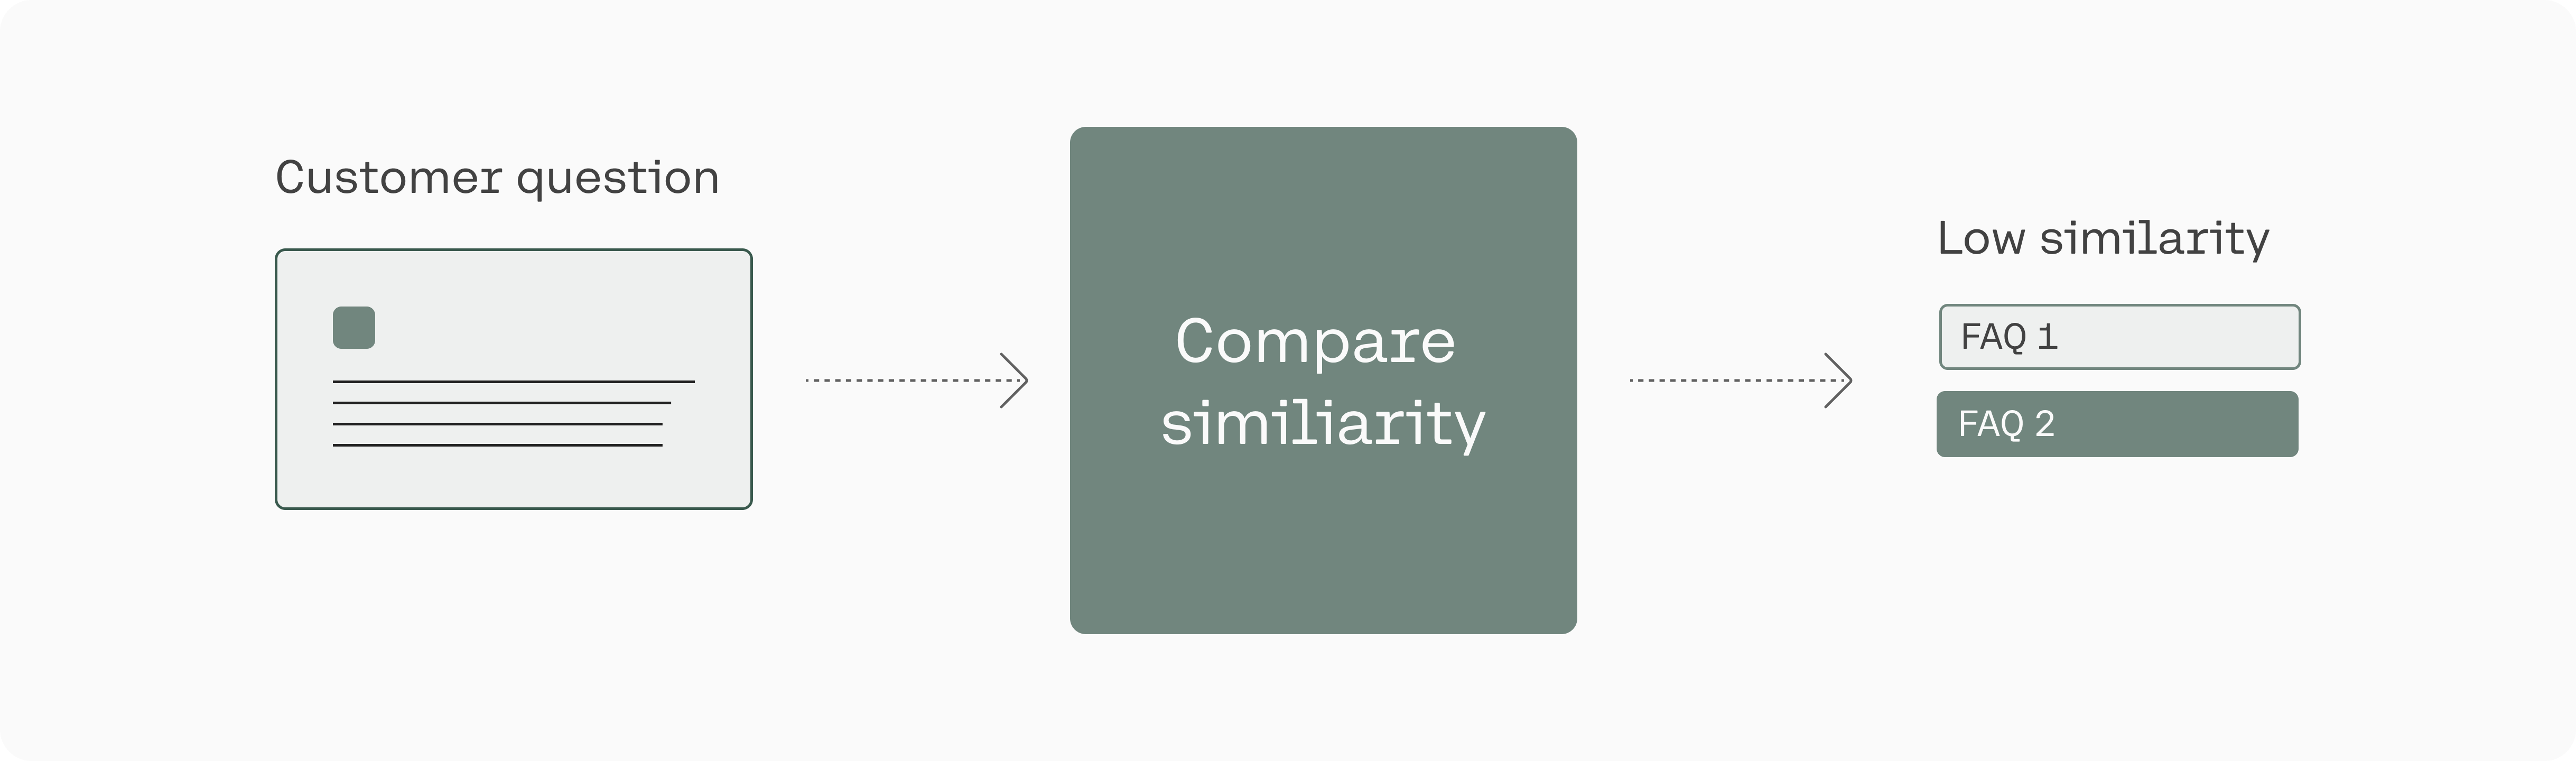

## Fine-tune BERT for sentence-pair classification

### What's this notebook about?

You will learn in this notebook how to fine-tune BERT-based models for the **sentence-pair classification** task. 

This TensorFlow implementation leverages the Hugging face *Transformers* and *Datasets* libraries to download pre-trained models, enable quick research experiments and evaluation metrics.

This task is part of the semantic textual similarity problem. You have two pair of questions and you want to model the textual interaction between them.

We will be using the popular **Quora Question Pairs (QQP) dataset**, which is part of the General Language Understanding Evaluation (GLUE) benchmark. Given a pair of questions, our model will predict whether they are paraphrases of each other or not.

**Pre-requisites to understand this notebook** :
* Good theoretical understanding of transformer-based models, especially BERT.
* End-to-end understanding of the first notebook, which covers the fundamentals of Huggingface's transformers library and its usage for NLP tasks.

> By the end of this notebook, you will be able to: 
1. Understand the concept of sentence-pair classification and its application in NLP tasks.
2. Learn how to fine-tune a pre-trained BERT-based model for sentence-pair classification using Huggingface's transformers library and TensorFlow.
3. Use the Quora Question Pair dataset as an example for training the model.
4. Evaluate the model's performance using F1 score and accuracy metrics.
5. Explore different BERT-based models such as BERT, ALBERT, etc., and compare their performance with the fine-tuned model.
6. Customize the fine-tuned model for your own sentence-pair classification tasks.


*So let's start our journey to fine-tune Transformers.*

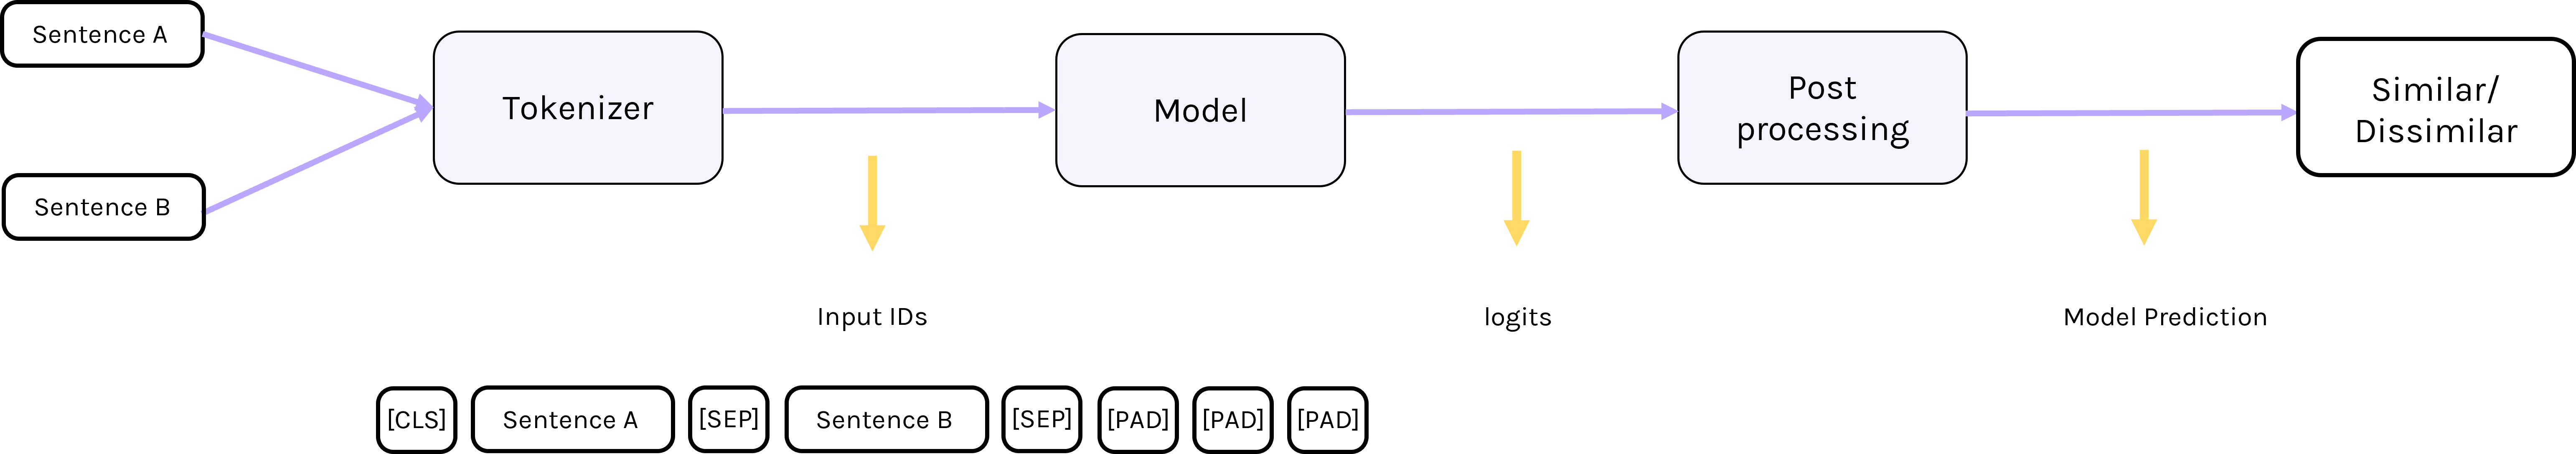

## Task 0: Installing libraries & loading packages

You need to install the transformers library & datasets from HuggingFace. You can do this by running the following command in your Colab notebook:

In [ ]:
# Install required packages
!pip -qq install datasets transformers[sentencepiece]

# !pip install transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

This will install the latest version of the library.

Once the libraries are installed, import the necessary packages

In [ ]:
# Import required libraries
import os
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import tensorflow as tf

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from datasets import load_dataset
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from datasets import Dataset, DatasetDict

# Disable parallelism for tokenizers to avoid issues with multi-threading in Colab
os.environ["TOKENIZERS_PARALLELISM"] = "false"

## **Task 1.1: Load the dataset**

Once, the packages are installed, you need to load the dataset by mounting your google drive and loading files from it

In [ ]:
# Import the required library to mount Google Drive
from google.colab import drive

# Mount your Google Drive to the Colab notebook
drive.mount('/content/drive')

In [ ]:
# Read the training data from a CSV file stored in your Google Drive
train = pd.read_csv('/content/drive/MyDrive/sentence_pair_classification_data/train.csv')

In [ ]:
# Display a sample of 5 rows from the training data
train.sample(5)

In [ ]:
# Inspecting the data size
train.shape

### **Task 1.1.1: Reading data as Huggingface dataset object**

A **Dataset object** is a convenient way to handle data in machine learning projects. It is a Python object that stores data in a standard format and can be easily accessed and manipulated. 

In this particular use case, the dataset object is used to read in the train, validation, and test data from .csv files and convert them into a format that can be used by the Hugging Face library for fine-tuning.

In [ ]:
# Load the train, validation, and test data as a dataset object from csv files using the load_dataset() function
dataset = load_dataset('csv', data_files={'train': '/content/drive/MyDrive/sentence_pair_classification_data/train.csv',\
                                          'valid':'/content/drive/MyDrive/sentence_pair_classification_data/val.csv',
                                          'test': '/content/drive/MyDrive/sentence_pair_classification_data/test.csv'},)


# Once all the files are loaded, you can read the dataset object by calling it
dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-be0e0a184f9e9ec0/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 363846
    })
    valid: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx'],
        num_rows: 390965
    })
})

The `load_dataset()` function takes two parameters: 
* Name of the dataset format, which is 'csv' in this case.
* A dictionary of data files containing the data. The keys of the dictionary correspond to the different splits of the data, which are 'train', 'valid', and 'test' in this case. 
> The values of the dictionary are the file paths to the corresponding csv files. The function returns a DatasetDict object that contains the data in a standard format that can be easily used by the Hugging Face library for fine-tuning.

 From the output, we can see that the dataset object has three subsets: train, valid, and test.
 
Each of these subsets has the same set of four features: **'question1', 'question2', 'label', and 'idx'.**

The number of rows in each subset are as following:. 
* Training subset has 363846 rows, 
* Validation subset has 40430 rows, 
* Testing subset has 390965 rows. 

## **Task 2: Data preprocessing**

After loading the data as a **Dataset** object, the next step is to preprocess the data using the appropriate tokenizer. In this notebook, we will be using the `bert-base-cased` model for sentence classification, so we will initialize it using the model checkpoint that we can use to load the respective tokenizer.


Once the transformers library is installed, we can initialize the tokenizer using the `AutoTokenizer` class and the name of the pre-trained model checkpoint, which is `bert-base-cased` in our case:

In [ ]:
# Define the BERT model checkpoint that we will use to load the tokenizer
model_checkpoint = "bert-base-cased"

# Define the batch size for the training
batch_size = 32

In [ ]:
# Load the tokenizer for the specified model checkpoint using Hugging Face AutoTokenizer
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

We can now use this tokenizer to preprocess the data and tokenize the sentences. 

This will involve converting each sentence into a sequence of token IDs and adding the necessary special tokens like [CLS] and [SEP]. We will also apply padding and truncation to ensure that all the sequences have the same length.

> Note that the tokenizer can be used to preprocess multiple inputs simultaneously, which is useful for sentence classification tasks where we need to process pairs of sentences.

### **Task 2.1: Passing in the data**

After loading the dataset and initializing the tokenizer, the next step is to pass in the pairs of questions from the dataset to the tokenizer.

To preprocess the data, we will use a `preprocess_function()` that takes in a batch of data and applies the tokenizer to each sample in the batch. 
* The tokenizer will encode a pair of questions from the dataset, and we will set the max_length parameter to 75 to limit the sequence length. 
* We will also set the truncation parameter to True, which will truncate any sequences that exceed the max_length. 
* Finally, we will set `return_token_type_ids` to True, which will return token type IDs to distinguish between the two questions.

We will start by using the tokenizer to encode a pair of questions from the training dataset. This will give us an idea of what the encoded sequence looks like and how it can be used as input for the BERT model.

In [ ]:
# Use the tokenizer to encode a pair of questions from the training dataset
tokenizer(train.question1[0], train.question2[0], 
          padding='max_length',  # Pad to max_length
          truncation=True,  # Truncate to max_length
          max_length=75,  # Set the maximum length of the encoded sequence to 75
          return_tensors='tf',  # Return TensorFlow Tensor objects
          return_token_type_ids=True)  # Return token type IDs to distinguish between the two questions


{'input_ids': <tf.Tensor: shape=(1, 75), dtype=int32, numpy=
array([[  101,  1731,  1110,  1103,  1297,  1104,   170, 12523,  2377,
          136,  7426,  1128,  5594,  1240,  1319,  5758,   136,   102,
         5979,  1634,  1104,  3073, 20488,  2116,  1110,  1536,  1111,
         1103, 12211,   179,  1233,  6451,  1571,   136,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(1, 75), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0]], d

The output of the code is a dictionary containing three TensorFlow Tensor objects, namely input_ids, token_type_ids, and attention_mask.

* The **input_ids** Tensor contains the encoded input sequence of integers, where each integer represents a specific token in the input text. The maximum length of the encoded sequence is set to 75 using the max_length parameter.

* The **token_type_ids** Tensor is used to distinguish between the two questions in the input pair. In this case, it contains a sequence of 0s and 1s, where 0s represent tokens from the first question, and 1s represent tokens from the second question.

* The **attention_mask** Tensor is used to indicate which tokens in the input sequence should be attended to by the model and which should be ignored. It is also used to pad the input sequence to the maximum length specified by max_length. The attention_mask contains 1s for tokens that should be attended to and 0s for tokens that should be ignored or are padding tokens.

Now that we have applied a sample of paired sentences to the tokenizer and observed it's output, let's pass in the entire dataset to the tokenizer using a function

In [ ]:
# Define a function that takes in a dictionary of paired sentences and returns the tokenized input IDs, token type IDs, and attention masks
def preprocess_function(records):
    return tokenizer(records['question1'], records['question2'], truncation=True, return_token_type_ids=True, max_length=75)


The above code defines a function `preprocess_function()` that takes in a dictionary of paired sentences and tokenizes them using the Hugging Face tokenizer. It applies truncation, sets return_token_type_ids=True, and limits the maximum length to 75 tokens.


Once, the function is defined, let's pass in the entire dataset to the function by calling the `.map()` function. This will tokenize all the sentences present in the dataset.

In [ ]:
# Tokenize the dataset using the previously defined preprocess function
encoded_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/363846 [00:00<?, ? examples/s]

Map:   0%|          | 0/40430 [00:00<?, ? examples/s]

Map:   0%|          | 0/390965 [00:00<?, ? examples/s]

In [ ]:
#Inspecting the encoded dataset
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 363846
    })
    valid: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 40430
    })
    test: Dataset({
        features: ['question1', 'question2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 390965
    })
})

The above operations transforms the dataset by adding multiple columns. To understand the list of columns added by the tokenizer, let's observe the original columns in the dataset

In [ ]:
# Create a set of columns present in the dataset
pre_tokenizer_columns = set(dataset["train"].features)

# Print the set of columns present in the dataset
pre_tokenizer_columns

{'idx', 'label', 'question1', 'question2'}

In [ ]:
# Create a list of columns added by the tokenizer
tokenizer_columns = list(set(encoded_dataset["train"].features) - pre_tokenizer_columns)

# Print the list of columns added by the tokenizer
print("Columns added by tokenizer:", tokenizer_columns)

Columns added by tokenizer: ['token_type_ids', 'input_ids', 'attention_mask']


### **Task 2.2: Data padding and batching**

While it's technically possible to use the encoded dataset directly, it's often not feasible to work with such large datasets directly. 

Therefore, after creating the encoded dataset, the next step is to convert it to a TensorFlow dataset.  Converting the encoded dataset to TensorFlow datasets allows for more efficient data loading and processing during model training. 


To convert the encoded dataset to a TensorFlow dataset, we will use the `DataCollatorWithPadding` class from the Transformers library. This class helps us to pad the encoded sequences so that they are all the same length, which is necessary for efficient training with TensorFlow.

Here are the steps for converting the encoded dataset to a TensorFlow dataset using `DataCollatorWithPadding`:

1. Create a `DataCollatorWithPadding` object, passing in the tokenizer and specifying that we want to return tensors in TensorFlow format.
2. Use the `to_tf_dataset()` method to convert the `encoded_dataset["train"]` and `encoded_dataset["valid"]` subsets to TensorFlow datasets, passing in the tokenizer_columns as the columns we want to use, **["labels"]** as the label columns, **True** as the value for the **shuffle** parameter for the training set and False for the validation set, and batch_size as the size of each batch. Pass in the `data_collator` object we created earlier as the `collate_fn` parameter.

In [ ]:
from transformers import DataCollatorWithPadding

# Create a DataCollatorWithPadding object with the tokenizer and return tensors in TensorFlow format
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

# Convert the encoded training set to a TensorFlow dataset
tf_train_dataset = encoded_dataset["train"].to_tf_dataset(
    columns=tokenizer_columns,  # Use the tokenizer columns as the input features
    label_cols=["labels"],  # Specify the label column
    shuffle=True,  # Shuffle the dataset
    batch_size=batch_size,  # Specify the batch size
    collate_fn=data_collator  # Use the data_collator to pad sequences
)

# Convert the encoded validation set to a TensorFlow dataset
tf_validation_dataset = encoded_dataset["valid"].to_tf_dataset(
    columns=tokenizer_columns,  # Use the tokenizer columns as the input features
    label_cols=["labels"],  # Specify the label column
    shuffle=False,  # Do not shuffle the dataset
    batch_size=batch_size,  # Specify the batch size
    collate_fn=data_collator  # Use the data_collator to pad sequences
)


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


The `DataCollatorWithPadding` class is used to define a collator function that will be used by the data loader to collate the tokenized input data into batches that can be fed to the model during training. The collator function also performs padding, which ensures that all inputs in a batch have the same length.

To understand how the above operation transforms the dataset, let's extract one batch of the dataset using the next() operation:

In [ ]:
# sample train batch
z = next(iter(tf_train_dataset))

# display the output in a human-readable format using the tokenizer's decode method. 
tokenizer.decode(z[0]['input_ids'][0])

'[CLS] How can I learn Google Adwords without having a website? [SEP] What is the best way to learn Google Adwords? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
tf_train_dataset_v2 = tf_train_dataset.take(100000)

Upon observing, the paired sentences in the above case are:
1. Which is the best video tutorial for Java?
2. What are some good video tutorials for Java? 

These two sentences are encoded with special tokens like [CLS], [SEP], and [PAD] to create input features for the model.

> * **[CLS]** token (stands for "classification") is used at the beginning of the input sequence and is used to represent the classification of the entire sequence. It's used for tasks such as text classification or sentiment analysis.
* **[SEP]** token is used to separate two different sentences in the input sequence.
* **[PAD]** token is used to pad sequences to a fixed length so that all sequences have the same length. This is necessary because the transformer models require fixed-length inputs. By default, the padding token is set to 0.

In [ ]:
# Number of classes in the classification task
num_labels = train.label.nunique()
num_labels

2

In the sentence similarity task, the labels typically represent whether two sentences are similar or dissimilar.

 So, in this case, the two labels could represent **"similar"** and **"not similar"** or **"duplicate"** and **"not duplicate"**, depending on the specific dataset and task.

## **Task 3: Training the model**

### **Task 3.1:Loading the model checkpoint**



After creating the TensorFlow dataset, the next set of tasks typically involves defining the training configuration and fine-tuning the pre-trained model on the dataset. 

This includes the following steps:

* Load the pre-trained model checkpoint 

* Define the training configuration, including the batch size, learning rate, number of epochs, and evaluation metrics.

* Fine-tune the model on the training dataset.

* Evaluate the fine-tuned model on the validation dataset, using the specified evaluation metrics.

* Once the model has been fine-tuned and evaluated, it can be used to make predictions on new data.







In [ ]:
# Load the pre-trained model with a sequence classification head
model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We have used `TFAutoModelForSequenceClassification` to automatically download the pre-trained model defined through model checkpoint earlier. Here:

* `TFAutoModelForSequenceClassification` is a class from the transformers library that loads a pre-trained model with a sequence classification head for fine-tuning on a specific classification task.

* `from_pretrained()` is a method of the TFAutoModelForSequenceClassification class that loads the pre-trained model from the specified checkpoint directory.

* `model_checkpoint` is a string specifying the directory path or the name of the pre-trained model checkpoint to be loaded.

* `num_labels` is an integer representing the number of classes in the classification task. In this case, it is the number of unique labels in the training set.

In [ ]:
{'n_estimators' : [10, 15, 20], 'max_features' : [12, 13, 14, 15], 'max_depth' : [20, 30, 40]}

### **Task 3.2:Configuring the hyperparameters**

Now that we have loaded the pre-trained model and prepared the dataset, we can proceed to fine-tuning the model. In this step, we will configure the optimizer and the learning rate schedule, and then train the model on the training dataset.

Here are the main steps we will follow:

1. Define the number of epochs to train the model for and calculate the number of training steps.
2. Configure the learning rate schedule using the `PolynomialDecay` class.
3. Define the optimizer using the `Adam` class.
4. Define the loss function using the `SparseCategoricalCrossentropy` class. This is the appropriate loss function for multi-class classification tasks where the target labels are integers.
5. Train the model on the training dataset using the `fit` method of the `TFAutoModelForSequenceClassification` class.


Let's start by defining the number of epochs and the number of training steps.

In [ ]:
# Define the number of epochs to train the model
num_epochs = 2

# Define the number of training steps by multiplying the number of samples in the dataset
# by the number of epochs. Note that the tf_train_dataset is a batched tf.data.Dataset, so its len() is already
# num_samples // batch_size.
num_train_steps = len(tf_train_dataset_v2) * num_epochs

# Define the learning rate scheduler using PolynomialDecay, which gradually decreases the learning rate.
# The initial learning rate is set to 5e-5, the end learning rate to 0.0, and the decay steps to the total
# number of training steps. The power is set to 2, which means that the learning rate will decrease quadratically.
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps, power = 2
)

# Define the optimizer using Adam, which is a popular optimization algorithm for deep learning.
# The learning rate is set to the learning rate scheduler defined above.
opt = Adam(learning_rate=lr_scheduler)

# Define the loss function as SparseCategoricalCrossentropy, which is used for multi-class classification problems
# with integer labels.
loss = SparseCategoricalCrossentropy(from_logits=True)


### **Task 3.3:Scheduling the Learning Rate** 



We define a learning rate schedule to gradually decrease the learning rate during training. This can help the model converge to a better solution by taking smaller steps towards the minimum of the loss function as the training progresses. 

To execute this, we use a polynomial decay function, which is implemented in the `PolynomialDecay` class from the TensorFlow Addons library. 

> The `PolynomialDecay` function takes the initial **learning rate, the number of decay steps, and a power value** that controls the rate of decay. 

Before training, we create a list of learning rates for each training step. We calculate the learning rate at each step by applying a polynomial decay function to the initial learning rate, with a decay rate that decreases quadratically from 1 to 0 over the course of the training. 


In [ ]:
lr_schedule = []

# Calculate the learning rate decay for each step in the decay schedule
for step in range(lr_scheduler.decay_steps):

    decay = (1 - (step / float(lr_scheduler.decay_steps))) ** lr_scheduler.power
    lr = lr_scheduler.initial_learning_rate * decay
    lr_schedule.append(lr)


Here we perform the following steps:

* We start by iterating over the number of decay steps, and for each step, computing the decay as a function of the step number and the decay power specified in `lr_scheduler`. 
* We then multiply the decay factor by the initial learning rate specified in `lr_scheduler` to obtain the learning rate for the current step. 
* We append each learning rate to the lr_schedule list.

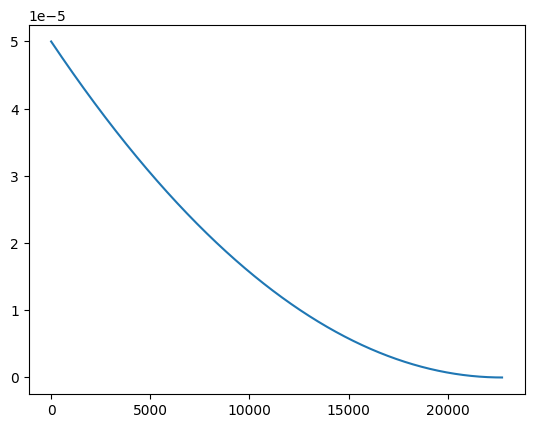

In [ ]:
#Visualising how the learning rate decays using the PolynomialDecay function
plt.plot(lr_schedule)

### **Task 3.4:Compile & Train the model** 


Now that we have defined the optimizer, learning rate schedule, and loss function, we can compile and train the model. The `compile()` function configures the model for training by specifying the optimizer, loss function, and evaluation metrics. We use the `SparseCategoricalCrossentropy` loss function as we have multiple classes to classify.

* After the model is compiled, we train it using the `fit()` function. We pass in the `tf_train_dataset` for training and the `tf_validation_dataset` for validation. We train the model for num_epochs epochs.

* Finally, we save the trained model to a directory using the save_pretrained() method. This allows us to reload the model later for inference or further fine-tuning.

In [ ]:
# Compile the model by specifying the optimizer, loss function, and evaluation metrics
model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

# Train the model using the fit() function
model.fit(tf_train_dataset_v2, validation_data=tf_validation_dataset, epochs=num_epochs)

# Save the trained model to a directory using the save_pretrained() method
model.save_pretrained("/content/drive/MyDrive/saved_model_epoch2/")

Epoch 1/2
 6485/11371 [================>.............] - ETA: 34:45 - loss: 0.3272 - accuracy: 0.8533

## **Task 4: Model Inference**

### **Task 4.1: Loading the trained model**

We start by loading the trained model from the saved checkpoint. Here we use `TFAutoModelForSequenceClassification` class to automatically download the pre-trained model defined through model checkpoint earlier.

In [ ]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('/content/drive/MyDrive/qqp_finetuned_model/',num_labels = num_labels)

### **Task 4.2: Checking similarity of input sentence pair**


Next, we define a function `check_similarity()` that takes two questions as input and checks if they mean the same thing. We first tokenize the input questions and then pass them through the loaded model to get the logits. 

We then compute the predicted class ID and return the output based on whether the predicted class ID is 1 or 0.

In [ ]:
def check_similarity(question1, question2):
    # Tokenize the input questions
    tokenizer_output = tokenizer(question1, question2, truncation=True, return_token_type_ids=True, max_length=75, return_tensors='tf')
    
    # Pass the tokenized input through the model
    logits = trained_model(**tokenizer_output)["logits"]
    
    # Compute the predicted class ID
    predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])
    
    # Return the output based on the predicted class ID
    if predicted_class_id == 1:
        return "Both questions mean the same"
    else:
        return "Both the questions are different."


**Testing the similarity checking function**

Finally, we test the check_similarity function with two pairs of questions to see if they are similar or not.

In [ ]:
check_similarity("Why are people so obsessed with cricket?", "Why are people so obsessed with football?")

In [ ]:
check_similarity("Why are people so obsessed with cricket?", "Why do people like cricket?")